# Peroxisome classification using Gaussian process follow prediction
- [x] Load image, masking and prediction table
- [ ] Mixed model - 80 Kernel 
- [ ] Trace with Kernel 5
- [ ] Varyings Effect model
- [ ] Calculate distance matrix
- [ ] Gaussian process
- [ ] Display Model on images


In [1]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

from jupyter_dash import JupyterDash
import dash
from dash import dcc 
from dash import html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageDraw,ImageFont
import seaborn as sns
#sns.set()
import arviz as az
import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import os
import re
import glob
import random
import plotnine
from sklearn import preprocessing
from tqdm import tqdm

import plotnine 
from plotnine.data import economics 
from plotnine import * 
import plotly.express as px

from skimage import measure, restoration,morphology
from skimage import io, filters, measure, color, img_as_ubyte
from skimage.draw import disk
from skimage import measure, restoration,morphology

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)


%config InlineBackend.figure_format = 'retina'
os.chdir(r'F:\HAB_2\PrinzScreen\training_classfication')
from utils import AIPS_cellpose as AC
from utils import AIPS_file_display as AFD

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


3.11.5


F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.


In [ ]:
def pm_table_from_image(path,image_number = 1,kernel_size=20):
    os.chdir(path)
    images_name = glob.glob("*.tif")
    AIPS_pose_object = AC.AIPS_cellpose(Image_name = images_name[image_number], path= path, model_type="cyto", channels=[0,0])
    img = AIPS_pose_object.cellpose_image_load()
    # create mask for the entire image
    mask, table = AIPS_pose_object.cellpose_segmantation(image_input=img[0,:,:])
    table_gran_temp = AIPS_pose_object.measure_properties(input_image=img[0,:,:])
    table_gran = pd.DataFrame(table_gran_temp['mean_int'].tolist())
    open_vec = np.linspace(1, 80, kernel_size, endpoint=False, dtype=int)
    for i in range(1, len(open_vec)):
        selem = morphology.disk(open_vec[i], dtype=bool)
        eros_pix = morphology.erosion(img[0,:,:], selem=selem)
        rec = morphology.dilation(eros_pix, selem=selem)
        table_gran_temp = AIPS_pose_object.measure_properties(input_image=rec)
        table_gran[int(open_vec[i])] = table_gran_temp['mean_int'].tolist()
    table_ = pd.DataFrame({'label':table.index.values,'area':table['area'].values,'centroid-0':table['centroid-0'].values,'centroid-1':table['centroid-1'].values})
    table_gran_comp = pd.concat((table_,table_gran),1)
    table_gran_comp = table_gran_comp.melt(id_vars=["label", "area","centroid-0","centroid-1"])
    table_out = table_gran_comp.sort_values(['label','variable']).reset_index(drop=True)
    table_out = table_out.rename(columns={"label":"image_group","variable": "raius_list", "value": "image_signal"})
    from sklearn import preprocessing
    table_sel = table_out
    # class_name =  table_sel['class'].values
    image_group =  table_sel['image_group'].values
    le = preprocessing.LabelEncoder()
    # encoding
    # class_name_encoded=le.fit_transform(class_name).tolist()
    image_group_encoded=le.fit_transform(image_group).tolist()
    table_dict={'image_signal':table_sel.image_signal.values.tolist(),
                'raius_list':table_sel.raius_list.values.tolist(),
                'image_group':image_group_encoded}
    table_fin = pd.DataFrame(table_dict)
    table_fin['image_group'] = pd.Categorical(table_fin['image_group'], ordered=False)
    return table_fin, mask, img,table_
path_norm = r'F:/HAB_2/PrinzScreen/training_classfication/raw/mix/selected_images'
table_img, mask,img, table = pm_table_from_image(path_norm,image_number=0,kernel_size=80)

In [ ]:
table_img['image_signal'] = table_img.image_signal.values/2**16
table_img['raius_list'] = table_img.raius_list.values +1
table_img

In [ ]:
# PLot observation - Image signal as function of time
# Random color function
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

un_names = np.unique(table_img['image_group'])
cmap = get_cmap(len(un_names))
fig = plt.figure()
x = np.linspace(1,80,80,dtype='int').tolist()
ax = fig.add_subplot(1, 1, 1)
for i,un_name in enumerate(un_names):
    teble_temp = table_img.loc[lambda x: (x['image_group'] == un_name),:]   
    y = teble_temp.image_signal.tolist()
    ax.plot(x, y, color=cmap(i))
    


In [ ]:
aa = np.array(table_img['image_group'])
_, idx__ = np.unique(aa, return_index=True)
id__ = np.array(np.repeat(aa[np.sort(idx__)],80))
opening_opr__ = np.array(table_img.raius_list.values) # 55*20
opening_opr__ = opening_opr__ + 1
signal__ = np.array(table_img.image_signal.values) # 55*20
id_paramaters__ = len(idx__)

print('Number of observations:{}'.format(id_paramaters__))
print('id:{}'.format(len(id__)))
print('opening_opr:{}'.format(len(opening_opr__)))
print('signal:{}'.format(len(signal__)))

- [ ] Load image, masking and prediction table
- [x] Mixed model - 80 Kernel 
- [ ] Trace with Kernel 5
- [ ] Varyings Effect model
- [ ] Calculate distance matrix
- [ ] Gaussian process
- [ ] Display Model on images

In [ ]:
def model_factory(x,y, z, sig):
    with pm.Model() as model:
        a = pm.Normal('a',0.05,0.1,shape= y)
        b = pm.Exponential('b',0.1,shape= y)
        c = pm.Normal('c',0.5,0.1,shape= y)
    
        mu = a[z] + c[z] * tt.exp(-b[z] * x)  # linear model
        sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
        signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=sig)  # likelihood
    return model

In [ ]:
with model_factory(x=opening_opr__,
                   y=id_paramaters__,
                   z=id__,
                   sig=signal__) as train_model:
    train_trace = pm.sample(4000, tune=4000, target_accept=0.9,random_seed=RANDOM_SEED)

- [ ] Load image, masking and prediction table
- [ ] Mixed model - 80 Kernel 
- [x] Trace with Kernel 5
- [ ] Varyings Effect model
- [ ] Calculate distance matrix
- [ ] Gaussian process
- [ ] Display Model on images

In [ ]:
path_norm = r'F:/HAB_2/PrinzScreen/training_classfication/raw/mix/selected_images'
table_img_test, mask_test,img_test, table_test = pm_table_from_image(path_norm,image_number=1,kernel_size=5)
table_img_test['image_signal'] = table_img_test.image_signal.values/2**16
table_img_test['raius_list'] = table_img_test.raius_list.values +1
table_img_test

In [ ]:
aa = np.array(table_img_test['image_group'])
_, idx__ = np.unique(aa, return_index=True)
id_test = np.array(np.repeat(aa[np.sort(idx__)],5))
opening_opr__test = np.array(table_img_test.raius_list.values) # 55*20
opening_opr__test = opening_opr__test + 1
signal__test = np.array(table_img_test.image_signal.values) # 55*20
id_paramaters__test = len(idx__)

print('Number of observations:{}'.format(id_paramaters__test))
print('id:{}'.format(len(id_test)))
print('opening_opr:{}'.format(len(opening_opr__test)))
print('signal:{}'.format(len(signal__test)))

In [ ]:
with open(os.path.join(path_output_train_simple_model,'simple_model_decay_Image_0_80kernel.pkl'), 'rb') as buff:  
    data = pickle.load(buff)  
test_trace = data['trace']  

In [ ]:
with model_factory(x=opening_opr__test,
                   y=id_paramaters__test,
                   z=id_test,
                   sig=signal__test) as test_model:
    # We first have to extract the learnt global effect from the train_trace
    df = pm.trace_to_dataframe(test_trace,
                               varnames=["a","b","c",'sigma_within'],
                               include_transformed=True)
    # We have to supply the samples kwarg because it cannot be inferred if the
    # input trace is not a MultiTrace instance
    p_post = pm.sample_posterior_predictive(trace=df.to_dict('records'),var_names=["a","b","c",'sigma_within'],
                                         samples=1000)

In [ ]:
path_output_train_simple_model = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kerenl_80_image_0_train'
path_output_test_simple_model = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kerenl_5_image_1_test'
########## Train data #########
# save images and table from paramters
os.chdir(path_output_train_simple_model)
np.save('mask_image0.npy',mask)
np.save('img_image0.npy',img)
table_img.to_csv('table_img.csv')  
table.to_csv('table.csv')  
import pickle
with open(os.path.join(path_output_train_simple_model,'simple_model_decay_Image_0_80kernel.pkl'), 'wb') as buff:  
    pickle.dump({'trace': train_trace, }, buff)

########## Test data #########
# save images and table from paramters
os.chdir(path_output_test_simple_model)
np.save('mask_image_1.npy',mask)
np.save('img_image_1.npy',img_test)
table_img_test.to_csv('table_img_test.csv')  
table_test.to_csv('table_test.csv')  
import pickle
with open(os.path.join(path_output_test_simple_model,'p_post_simple_model_decay_Image_0_80kernel.pkl'), 'wb') as buff:  
    pickle.dump({'p_post': p_post, }, buff)

In [ ]:
with open(os.path.join(path_output_test_simple_model,'p_post_simple_model_decay_Image_0_80kernel.pkl'), 'rb') as buff:  
    data = pickle.load(buff)  
test = data['p_post']  

In [41]:
path_output_train_simple_model = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kerenl_80_image_0_train'
table = pd.read_csv(os.path.join(path_output_train_simple_model,'table.csv'))
table_img = pd.read_csv(os.path.join(path_output_train_simple_model,'table_img.csv'))

# Varyings Effect
- [ ] Load image, masking and prediction table
- [ ] Mixed model - 80 Kernel 
- [ ] Trace with Kernel 5
- [x] Varyings Effect model
- [ ] Calculate distance matrix
- [ ] Gaussian process
- [ ] Display Model on images

$signal \sim Normal(y,\sigma)$\
$y = a + c \times e^{-b*filter} + \sigma $\
$a \sim Normal(50,20)$\
$b \sim Exponential(0.1)$\
$c \sim Normal(5,10)$\
$\sigma \sim Exponential(1)$\

In [3]:
table_img_new = table_img
#table_img_new['image_group'] = table_img_new.image_group -1
id__ = table_img_new.image_group.astype(int).values
Nid = len(np.unique(id__))
opening_opr__ = table_img_new.raius_list.values -1
Nopening_opr = len(np.unique(opening_opr__))
print('id__:{}'.format(len(id__)))
print('Nid:{}'.format(Nid))
print('opening_opr__:{}'.format(len(opening_opr__)))
print('Nopening_opr:{}'.format(Nopening_opr))

id__:5360
Nid:67
opening_opr__:5360
Nopening_opr:80


In [ ]:
a = pm.Normal('a',0.05,0.1,shape= y)
b = pm.Exponential('b',0.1,shape= y)
c = pm.Normal('c',0.5,0.1,shape= y)

In [ ]:
def model_factory(group1_num,group2_num, group1_arr, group2_arr,y):
    '''
    group1_num: number of observation of cluster one  
    group2_num: number of observation of cluster two   
    group1_arr: index aray of cluster one  
    group2_arr: index aray of cluster two
    y: observation summary
    '''
    with pm.Model() as model:
        intercept = pm.Normal("intercept", mu=0.05, sd=0.01, shape=group1_num)
        rate = pm.Exponential("rate", 0.1, shape=group1_num)
        slope = pm.Normal("slope", mu=0.05, sd=0.01, shape=group1_num)
        mu = intercept[group1_arr] + slope[group2_arr,group1_arr]  # linear model
        sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
        signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=y)  # likelihood
    return model

In [31]:
def model_factory(group1_num,group2_num, group1_arr, group2_arr,y):
    '''
    group1_num: number of observation of cluster one  
    group2_num: number of observation of cluster two   
    group1_arr: index aray of cluster one  
    group2_arr: index aray of cluster two
    y: observation summary
    '''
    with pm.Model() as model:
        intercept = pm.Normal("a", mu=0.05, sd=0.01, shape=group1_num)
        sd_slope = pm.Exponential.dist(0.01)
        chol_slope, _, _ = pm.LKJCholeskyCov("chol_slope", n=group1_num, eta=1, sd_dist=sd_slope, compute_corr=True)
        #chol_rate, _, _ = pm.LKJCholeskyCov("chol_rate", n=group1_num, eta=4, sd_dist=sd_slope, compute_corr=True)
        slope = pm.MvNormal("slope", mu=0.05, chol=chol_slope, shape=(group2_num, group1_num))
        #rate = pm.MvNormal("rate", mu=0, chol=chol_rate, shape=(group2_num, group1_num))
        mu = intercept[group1_arr] + slope[group2_arr,group1_arr]  # linear model
        sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
        signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=y)  # likelihood
    return model

In [34]:
with model_factory(group1_num=Nid,
                   group2_num=Nopening_opr,
                   group1_arr=id__,
                   group2_arr=opening_opr__,
                    y = table_img_new.image_signal) as train_model:
    train_trace = pm.sample(4000, tune=4000,random_seed=RANDOM_SEED,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


TypeError: function() got an unexpected keyword argument 'core'

In [ ]:
np.arange(2500)

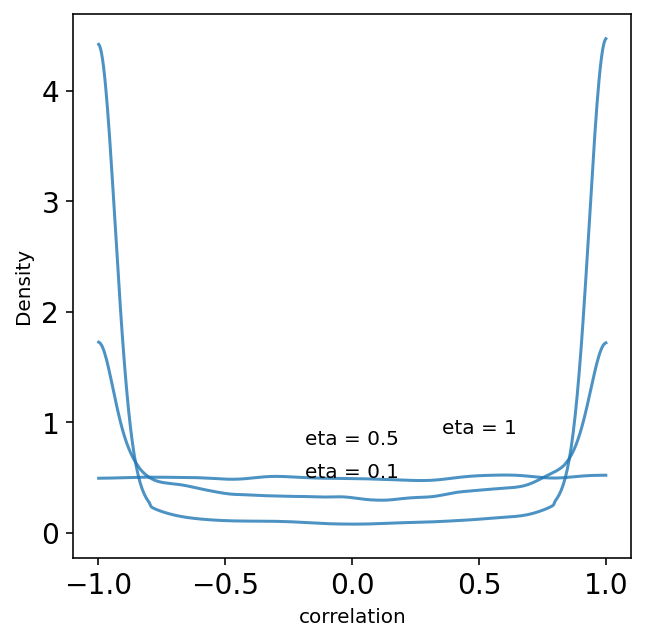

In [28]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for eta, loc in zip([0.1,0.5, 1, 2, 4,8,10], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    az.plot_kde(R, plot_kwargs={"alpha": 0.8})
    ax.text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

2.5

In [195]:
with pm.Model() as model_varyings_effect:
    # fixed priors
    a = pm.Normal("a", mu=0.05, sd=0.1, shape=Nid)
    sd_slope = pm.Exponential.dist(1)
    chol_slope, _, _ = pm.LKJCholeskyCov("chol_slope", n=Nid, eta=4, sd_dist=sd_slope, compute_corr=True)
    chol_rate, _, _ = pm.LKJCholeskyCov("chol_rate", n=Nid, eta=4, sd_dist=sd_slope, compute_corr=True)
    slope = pm.MvNormal("slope", mu=0.05, chol=chol_slope, shape=(Nopening_opr, Nid))
    rate = pm.MvNormal("rate", mu=0.05, chol=chol_rate, shape=(Nopening_opr, Nid))
    mu = a[id__] + slope[opening_opr__,id__] * tt.exp(-rate[opening_opr__,id__])
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=table_img_new.image_signal)  # likelihood
    train_trace = pm.sample(1, tune=1, target_accept=0.9)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_within, rate, slope, chol_rate, chol_slope, a]


Sampling 4 chains for 1 tune and 1 draw iterations (4 + 4 draws total) took 50 seconds.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\base.py:225: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, bu

In [205]:
test = train_trace['rate']
np.shape(test)

(4, 80, 67)

In [210]:
1500/12

125.0

In [212]:
1800-(180+394+125+(1800/12))

951.0

In [48]:
with pm.Model() as model_varyings_effect:
    # fixed priors
    a = pm.Normal("a", mu=0.05, sd=0.1, shape=id_paramaters__)
    
    sd_slope = pm.Exponential.dist(1)
    chol_slope, _, _ = pm.LKJCholeskyCov(
        "chol_slope", n=id_paramaters__, eta=4, sd_dist=sd_slope, compute_corr=True
    )
#     sd_decay = pm.Exponential.dist(1)
#     chol_decay, _, _ = pm.LKJCholeskyCov(
#         "chol_decay", n=id_paramaters__, eta=4, sd_dist=sd_decay, compute_corr=True
#     )
    
    # adaptive priors
    slope = pm.MvNormal("slope", mu=0, chol=chol_slope, shape=(opening_opr__un,id_paramaters__))
    #decay = pm.MvNormal("decay", mu=0.5, chol=chol_decay, shape=(opening_opr__un,id_paramaters__))
    
    mu = a[id__] + slope[id__,opening_opr__] * tt.exp(-b[z] * x)  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=signal__)  # likelihood
    train_trace = pm.sample(4000, tune=4000, target_accept=0.9)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
mu = a[z] + c[z] * tt.exp(-b[z] * x)  # linear model
        sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
        signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=sig)  # likelihood

# Peroxisome classification using Gaussian process follow prediction
- [ ] Load image, masking and prediction table
- [ ] Mixed model - 80 Kernel 
- [ ] Trace with Kernel 5
- [ ] Varyings Effect model
- [x] Calculate distance matrix
- [ ] Gaussian process
- [ ] Display Model on images

In [2]:
path_output_train_simple_model = r'F:\HAB_2\PrinzScreen\output_lab_meeting\Kerenl_80_image_0_train'
table = pd.read_csv(os.path.join(path_output_train_simple_model,'table.csv'))
table_img = pd.read_csv(os.path.join(path_output_train_simple_model,'table_img.csv'))
table_micron = table

In [3]:
table_micron

Unnamed: 0  label  area  centroid-0  centroid-1
0            0      1  2383   23.901804   23.626102
1            1      2  1523   13.389363  109.061064
2            2      3  3331   20.785950  209.126689
3            3      4  1658   24.376960  358.218938
4            4      5  2442   29.977477  394.630631
..         ...    ...   ...         ...         ...
62          62     63  3947  456.397010  346.923486
63          63     64  2787  487.859347  417.740222
64          64     65  2190  490.971233  485.043379
65          65     66  2063  498.865245   41.897722
66          66     67  2269  496.646981  332.263552

[67 rows x 5 columns]

In [3]:
from scipy.spatial import distance_matrix
# table change nano distance to micron
table_micron.loc[:,['centroid-0','centroid-1']] = (table_micron.loc[:,['centroid-0','centroid-1']])/1000
#df = pd.DataFrame(table_micron, columns=['centroid-0', 'centroid-1'], index=table_micron.index.values.tolist())
df = pd.DataFrame(table_micron, columns=['centroid-0', 'centroid-1'])
dmat = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
#dmat = dmat.iloc[:66,:]
dmat = np.array(dmat)
dmat = dmat + 0.000000001
dmat
# Dmatsq = dmat**2
# Dmatsq = Dmatsq +1
# Dmatsq

array([[1.00000000e-09, 8.60792911e-02, 1.85526755e-01, 3.34593175e-01,
        3.71054275e-01, 4.42889357e-01, 2.52340864e-01, 1.16659205e-01,
        4.71132749e-02, 3.18767360e-01, 1.78086199e-01, 2.45739856e-01,
        4.32545481e-01, 5.00121031e-02, 4.78736268e-01, 6.28067501e-02,
        1.00731448e-01, 4.45093632e-01, 2.71404463e-01, 1.33800223e-01,
        1.64716807e-01, 3.45598181e-01, 3.59908945e-01, 3.71398514e-01,
        1.54964354e-01, 3.76459387e-01, 3.80692104e-01, 2.39625921e-01,
        5.10059318e-01, 4.85198514e-01, 4.59285948e-01, 3.07223261e-01,
        2.03457579e-01, 2.27830980e-01, 4.52228060e-01, 4.02427711e-01,
        5.38509122e-01, 2.44441426e-01, 4.96164887e-01, 2.47497303e-01,
        3.17107545e-01, 3.82606659e-01, 4.12168234e-01, 2.78036971e-01,
        2.89579064e-01, 5.22955218e-01, 4.74473294e-01, 3.19774163e-01,
        3.47441412e-01, 4.24196946e-01, 5.84314250e-01, 3.94366304e-01,
        3.70170542e-01, 5.07715726e-01, 5.99593787e-01, 3.696682

In [5]:
np.shape(dmat)

(67, 67)

In [126]:
dmat[0,0]

1e-09

- [ ] Load image, masking and prediction table
- [ ] Mixed model - 80 Kernel 
- [ ] Trace with Kernel 5
- [ ] Calculate distance matrix
- [x] Gaussian process
- [ ] Display Model on images

The Input for the Gaussian process will be the parameters predicted from the mixed model.

In [46]:
table_img

Unnamed: 0  image_signal  raius_list  image_group  image_signal_float
0              0      0.037009           1            0        5.647143e-07
1              1      0.034149           2            0        5.210677e-07
2              2      0.031115           3            0        4.747730e-07
3              3      0.028669           4            0        4.374527e-07
4              4      0.026942           5            0        4.110988e-07
...          ...           ...         ...          ...                 ...
5355        5355      0.005729          76           66        8.741554e-08
5356        5356      0.005729          77           66        8.741554e-08
5357        5357      0.005728          78           66        8.740877e-08
5358        5358      0.005728          79           66        8.740877e-08
5359        5359      0.005728          80           66        8.740846e-08

[5360 rows x 5 columns]

In [6]:
np.unique(table_img.image_group)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
      dtype=int64)

In [4]:
id_arr_uniqe = np.unique(table_img.image_group)
Nid = len(id_arr_uniqe)
id_arr = np.repeat(np.arange(Nid),80)
opr_arr_uniqe = np.linspace(0.1,0.80,80,endpoint=True)
Nopr = len(opr_arr_uniqe)
opr_arr = np.array(list(opr_arr_uniqe)*Nid)
print('id_arr_uniqe {}'.format(id_arr_uniqe))
print('Nid {}'.format(Nid))
print('id_arr {}'.format(id_arr))
print('opr_arr_uniqe {}'.format(opr_arr_uniqe))
print('Nopr {}'.format(Nopr))
print('opr_arr {}'.format(opr_arr))

id_arr_uniqe [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
Nid 67
id_arr [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  

In [ ]:
with pm.Model() as model:
    a = pm.Normal('a',0.05,0.1,shape = Nid )
    b = pm.Exponential('b',0.1,shape = Nid )
    c = pm.Normal('c',0.5,0.1,shape = Nid )
    etasq = pm.Exponential("etasq",0.5)
    ls_inv = pm.Exponential("ls_inv",1)
    cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    K = gp.prior("k", X=dmat)
    mu = a[id_arr] + c[id_arr]*tt.exp(-b[id_arr]*opr_arr) + K[id_arr]  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=table_img.image_signal)  # likelihood
    trace = pm.sample(4000, tune=4000,cores=1 ,random_seed=RANDOM_SEED,target_accept=0.9)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 67 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_within, k_rotated_, ls_inv, etasq, c, b, a]


In [ ]:
etasq = pm.Exponential("etasq",0.5)
ls_inv = pm.Exponential("ls_inv",1)
cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
gp = pm.gp.Latent(cov_func=cov)
K = gp.prior("k", X=dmat)

In [23]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self,intercept, slope, rate):
        self.intercept =intercept
        self.slope = slope
        self.rate =rate

    def __call__(self, X):
        """In the trace summary, b0 will be bM and b1 will be bG"""
        return self.intercept[id_arr] + self.slope[id_arr] * tt.exp(-self.rate[id_arr] * opr_arr_uniqe)

In [24]:
with pm.Model() as model:
    a = pm.Normal('a',0.05,0.1,shape = Nid )
    b = pm.Exponential('b',0.1,shape = Nid )
    c = pm.Normal('c',0.5,0.1,shape = Nid )
    mu = LinearMean(intercept=a, slope=b,rate=c)  # linear model
    
    etasq = pm.Exponential("etasq", 1.0)
    rhosq = pm.Normal("rhosq", 0.001, 0.1)
    # specify the covariance function:
    SIGMA = etasq * pm.gp.cov.Exponential(input_dim=1, ls=rhosq)
    gp = pm.gp.Marginal(mean_func=mu, cov_func=SIGMA)
    
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    # likelihood
    signal = gp.marginal_likelihood("signal", X=Dmat_ord[], y=signal__, noise=sigma_within)
    trace_14_11 = pm.sample(1, tune=1, target_accept=0.9)

IndexError: index 66 is out of bounds for axis 0 with size 66

In [ ]:
etasq = pm.Exponential("etasq",0.5)
ls_inv = pm.Exponential("ls_inv",1)
    cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    K = gp.prior("k", X=Dmatsq)

In [ ]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)

etasq = 1
cov = etasq * pm.gp.cov.ExpQuad(1, ls=2)

# .eval() evaluates the aesara op.  There will be a pause the first time as aesara compiles the function
Kxx = cov(x[:, None]).eval()

plt.imshow(Kxx);

In [ ]:
np.shape(Kxx)

In [ ]:
with pm.Model() as simple_model_decay:
    a = pm.Normal('a',50,20,shape= id_paramaters__)
    b = pm.Exponential('b',0.3,shape= id_paramaters__)
    c = pm.Normal('c',5,10,shape= id_paramaters__)
    
    mu = a[id__] + c[id__] * tt.exp(-b[id__] * opening_opr__)  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=signal__)  # likelihood
    
    id_paramaters = pm.Data("id_paramaters",id_paramaters__)
    id_ = pm.Data("id_",id__)
    opening_opr = pm.Data("opening_opr",opening_opr__)
    signal_ = pm.Data("signal_",signal__)
    
    trace_simple_model_decay = pm.sample(4000, tune=4000, target_accept=0.9)  # likelihood

In [ ]:
with pm.Model() as m14_11:
    a = pm.Normal("a", 0.0, 1.0)
    b = pm.Normal("b", 0.0, 0.5, shape=2)
    # specify the mean function:
    mu = LinearMean(intercept=a, slopes=b)

    # half_normal(1, 0.25) is too strong
    etasq = pm.Exponential("etasq", 1.0)
    rhosq = pm.Normal("rhosq", 3.0, 0.25)
    # specify the covariance function:
    SIGMA = etasq * pm.gp.cov.Exponential(input_dim=1, ls=rhosq)

    # specify the GP:
    gp = pm.gp.Marginal(mean_func=mu, cov_func=SIGMA)

    # place a GP prior over the observations.
    # SIGMA will be conditioned on Dmat_ord.
    # mu won't be, as we coded it on purpose.
    sigma = pm.Exponential("sigma", 1.0)
    B = gp.marginal_likelihood("B", X=Dmat_ord, y=B_, noise=sigma)

    trace_14_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_14_11 = az.from_pymc3(trace_14_11)

# b0 is bM and b1 is bG
az.summary(idata_14_11, round_to=2)

In [ ]:
# prediction table
b = np.mean(p_post['b'],0)
b_sd = np.std(p_post['b'],0)
c = np.mean(p_post['c'],0)
c_sd = np.std(p_post['c'],0)
a = np.mean(p_post['a'],0)
a_sd = np.std(p_post['a'],0)
uniqe_list_image_name = np.unique(table_img['image_group'])

df_pred = pd.DataFrame({'a':a,'b':b,'c':c,'a_sd':a_sd,'b_sd':b_sd,"c_sd":c_sd,'Image':uniqe_list_image_name})
table_pred = pd.concat((table,df_pred),1)
table_pred

In [ ]:
table_pred_c = table_pred
table_pred_c.rename({'c': 'predict'}, axis=1, inplace=True)
table_pred_c.rename({'centroid0': 'centroid-0','centroid1':'centroid-1'}, axis=1, inplace=True)
table_pred_c

In [ ]:
def pred_map(image_input,mask_input,table_input,round_n = 3,lable = 11, B = True):
    if B:
        blank = np.zeros_like(image_input)
        img_gs = img_as_ubyte(blank)
    else: 
        img_gs = img_as_ubyte(image_input)
    PIL_image = Image.fromarray(img_gs)
    # round
    info_table = table_pred_c.round({'centroid-0': 0, 'centroid-1': 0})
    info_table['predict_round'] = info_table.loc[:, 'predict'].astype(float).round(round_n)
    info_table['area_round'] = info_table.loc[:, 'area'].astype(float).round(round_n)
    info_table = info_table.reset_index(drop=True)
    draw = ImageDraw.Draw(PIL_image)
    # use a bitmap font
    font = ImageFont.truetype("arial.ttf", 10, encoding="unic")
    for i in range(len(info_table)):
        draw.text((info_table.iloc[i, 3].astype('int64'), info_table.iloc[i, 2].astype('int64')),
                  str(info_table.iloc[i, lable]), 'red', font=font)
    PIL_image_blank = Image.fromarray(img_as_ubyte(np.zeros_like(image_input)))
    PIL_image_input = Image.fromarray(img_as_ubyte(image_input))
    return PIL_image_blank,PIL_image_input,PIL_image 
PIL_image_blank,PIL_image_input,PIL_image  = pred_map(image_input = img[0,:,:]*4,mask_input = mask,table_input = table_img,round_n = 3,lable = 11, B = True)
Image.merge("RGB", (PIL_image_Blank,PIL_image,PIL_image_input))
    

In [ ]:
BETA = np.array([1.4, -0.6])
train_x = np.random.randn(100) * 3
train_y = np.polyval(BETA[::-1], train_x)
hold_out_x = np.linspace(-10, 10, 51)
hold_out_y = np.polyval(BETA[::-1], hold_out_x)

In [ ]:
np.shape(hold_out_y)